# **Auxiliary Classifier GAN (AC-GAN) to Deep Convolutional GAN (DCGAN)**
***Note***: This code recycles code from our Fully Connected AC-GAN, but replaces the fully connected layers for encoding image features with transposed convolution (i.e. fractionally strided convolution) in the Generator to achieve higher resolutions and traditional convolution in the Discriminator to capture features in learnable feature maps, as opposed to direct weights.

### Motivation

 After successfully augmenting the vanilla GAN with the Auxiliary Classifier, we knew that resolutional power was the next step to augment for any discernible textured clothes to be produced (as outlined in the "Inspirational Adversarial Image Generation" paper). DC-GAN was our augmentation of choice. Recall the resolution comparisons of the GANs lab from the course (see below):

<img src="https://drive.google.com/a/brown.edu/uc?id=1f-A7FwAfb2-hlGtUpJW0Yxl3UbKeFE8i&export=download" alt="gan_outputs_tf.png">




# **Setup**
Here we recycle supplementary code from the lab.

In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np

tf.keras.backend.set_floatx('float64')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]), cmap="gray_r")
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


# Load data from Google Drive
import io
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3', cache_discovery=False)

fid = "1r6i_ftDFkjFy6mUq-CNTH1JeN_C0xqDh"


from IPython.display import HTML, display
def progress_bar(value):
    return HTML("""
        <progress
            value='{value}'
            max='100', style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value*100))
request = drive_service.files().get_media(fileId=fid)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
progress_bar_html = display(progress_bar(0), display_id=True)
while not done:
  
  progress, done = downloader.next_chunk()
  progress_bar_html.update(progress_bar(progress.progress()))

print("Done.")
downloaded.seek(0)

# A dict with keys {"lrelu_x", "lrelu_y", "logits_real", "logits_fake", "d_loss_true", "g_loss_true"}
# Only used for testing your loss/activation functions, not for training your GAN
answers = np.load(downloaded)

Done.


## **Fashion MNIST Dataset**
Knowing from the lab that "GANs are notoriously finicky with hyperparameters, and also require many training epochs" we decided to start with the Fashion MNIST Dataset to kickstart the development of our model. This would make tuning and training much more manageable before augmenting classification, resolution, and ultimately textures and more robust datasets.

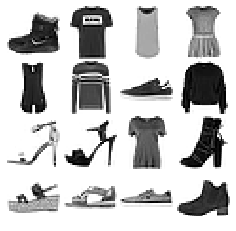

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

train_images = np.reshape(train_images, [train_images.shape[0], -1])
show_images(train_images[:16])
train_images = train_images / 255.0

mnist_images = tf.data.Dataset.from_tensor_slices(train_images)
mnist_labels = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int32))

mnist = tf.data.Dataset.zip((mnist_images, mnist_labels))

## **Random Noise and Labels**
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1, with concatenated one-hot label vectors of length `num_classes`, to produce shape `[batch_size, dim + num_classes]`, as well as a TensorFlow `Tensor` containingly the randomly generated labels from 0 to num_classes with shape `[batch_size,]` to be used in loss calculation.

In [ ]:
def modified_sample_noise(batch_size: int, dim: int, num_classes: int, testing=False, input_label=None) -> tf.Tensor:
    latent_tensor = tf.random.uniform(shape=[batch_size, dim], minval=-1, maxval=1) # [batch_size, dim]
    label_tensor = tf.random.uniform(shape=[batch_size], minval=0, maxval=num_classes, dtype=tf.int32)
    one_hot_labels = tf.one_hot(label_tensor, num_classes) # [batch_size, num_classes]

    if testing:
      label_tensor = input_label
      one_hot_labels = tf.one_hot(input_label, num_classes)

    tensor = tf.concat([latent_tensor, one_hot_labels], 1)

    return tensor, label_tensor

# **Building the Discriminator and the Generator**

Similarly to the lab, we separated the discriminator and the generator into two separate models for clarity and simplicity. While the layers in both are modeled after the vanilla GAN architecture from the lab, the key difference is found in the loss functions, as discussed earlier.

## Discriminator
The architecture of the discriminator was adapted from our AC-GAN reference in our write-up to include fewer layers to ease the training process.

The outputs of the discriminator should have shapes `[batch_size, 1]`, for whether each of the `batch_size` inputs are real images, and `[batch_size, 10]` for the probability predictions of the class labels.

The loss is the same from the Vanilla AC-GAN.

In [ ]:
class Discriminator(tf.keras.Model):
  
  """Model class for the discriminator"""
  def __init__(self,):
    super(Discriminator, self).__init__()
    
    self.binary_pred = tf.keras.layers.Dense(1)
    self.classifier = tf.keras.layers.Dense(10, activation='softmax')

    self.model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.4),
      
    tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.4),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
    ])

   
  @tf.function
  def call(self, x: tf.Tensor) -> tf.Tensor:
    """Compute discriminator scores and classification predictions for a batch 
    of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image,
    and TensorFlow Tensor with shape [batch_size, 10], containing the 
    probability predictions for the class labels.
    """
    weight = self.model(x)

    binary_pred = self.binary_pred(weight)
    class_pred = self.classifier(weight)

    return binary_pred, class_pred
    
  @tf.function
  def loss_function(self, logits_fake, logits_real, class_fake, class_real, class_labels_fake, class_labels_real):
    """Compute the loss for the discriminator that optimizies correct real vs fake prediction and category classification.

    Inputs:
    - logits_fake: binary_pred output of calling discriminator with fake images
    - logits_real: binary_pred output of calling discriminator with real images
    - class_fake: class_pred output of calling discriminator with fake images
    - class_real: class_pred output of calling discriminator with real images
    - class_labels_fake: class labels generated by modified_sample_noise, taken as input to generate fake images
    - class_labels_real: class labels associated with real images from dataset

    Returns:
    A scalar tensor with the average loss for the batch.
    """
    # traditional GAN loss
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits=logits_fake))
    D_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_real))

    # categorical classification loss
    class_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(class_labels_fake, class_fake)
    class_loss += tf.nn.sparse_softmax_cross_entropy_with_logits(class_labels_real, class_real)

    D_loss += class_loss

    return tf.reduce_mean(D_loss) 
    
        

## Generator
The architecture of the generator likewise takes after that of the reference, but simplified.

The loss is the same form Vanilla AC-GAN.

In [ ]:
class Generator(tf.keras.Model):
  
  """Model class for the generator"""
  def __init__(self):
    super(Generator, self).__init__()
    
    self.model = tf.keras.Sequential([
    tf.keras.layers.Dense(12544, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
      
    tf.keras.layers.Reshape((7, 7, 256)),
    
    tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])

   
  @tf.function
  def call(self, x: tf.Tensor) -> tf.Tensor:
    """Generates a batch of images given a tensor of noise + label vectors.
    
    Inputs:
    - x: A [batch_size, noise_dim + num_classes] tensor of noise + label vectors
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 784], containing the generated images.
    """
    return self.model(x)
    
  @tf.function
  def loss_function(self, logits_fake, class_fake, class_real, class_labels_fake, class_labels_real):
    """Compute the loss for the generator that maximizes incorrect discriminator 
    guess of fake as real and correct category classification by the discriminator.

    Inputs:
    - logits_fake: binary_pred output of calling discriminator with fake images
    - class_fake: class_pred output of calling discriminator with fake images
    - class_real: class_pred output of calling discriminator with real images
    - class_labels_fake: class labels generated by modified_sample_noise, taken as input to generate fake images
    - class_labels_real: class labels associated with real images from dataset

    Returns:
    A scalar tensor with the average loss for the batch.
    """
    # ones indicate guess as real
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels= tf.ones_like(logits_fake), logits=logits_fake))

    # get class_loss from discriminator
    class_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(class_labels_fake, class_fake)
    class_loss += tf.nn.sparse_softmax_cross_entropy_with_logits(class_labels_real, class_real)

    G_loss += class_loss

    return tf.reduce_mean(G_loss)
        

# Optimizing Loss and Training
Like usual, we optimize our loss we use the `Keras AdamOptimizer` with a 1e-3 learning rate and $\beta_1$ of 0.5. We use Gradient Tape to calculate and apply the gradients.

We then train over 10 epochs.

In [ ]:
learning_rate=1e-3
beta_1=0.5

# TODO: make an Adam Optimizer with a learning rate of 1e-3 and a beta_1 of 0.5
# to start (you will have to play with these values)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5)


def optimize(tape: tf.GradientTape, model: tf.keras.Model, loss: tf.Tensor) -> None:
  """ This optimizes a model with respect to its loss
  
  Inputs:
  - tape: the Gradient Tape
  - model: the model to be trained
  - loss: the model's loss
  """
  # TODO: calculate the gradients our input model and apply them
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  

In [ ]:
def accuracy(logits, labels):
      """
      Calculates the discriminator's classification accuracy by comparing
      logits to correct labels.
      
      :param logits: a matrix of size (num_inputs, num_classes); during training, this will be (batch_size, num_classes)
      containing the softmax probability predictions for each class
      :param labels: a matrix of size (num_inputs,) containing the answers, during training, this will be (batch_size,)
      
      :return: the accuracy of the model as a Tensor
      """
      correct_predictions = tf.equal(tf.cast(tf.argmax(logits, 1), tf.int32), labels)
      return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [ ]:
num_classes = 10

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 784

# create generator and discriminator
generator_model = Generator()
generator_model.build((None, noise_dim + num_classes))
discriminator_model = Discriminator()
discriminator_model.build((None, 28, 28, 1))

def train(x, c):
  # random noise fed into our generator
  z, class_labels_fake = modified_sample_noise(batch_size, noise_dim, num_classes)

  with tf.GradientTape(persistent=True) as tape:
    # generated images
    G_sample = generator_model(z)

    # scale images to be -1 to 1
    logits_real, class_real = discriminator_model(tf.reshape(preprocess_img(x), (128, 28, 28, 1)))
    # re-use discriminator weights on new inputs
    logits_fake, class_fake = discriminator_model(G_sample)
    # calculate mean fake and real classification accuracies
    real_class_acc = accuracy(logits_real, c)
    fake_class_acc = accuracy(logits_fake, class_labels_fake)
    batch_accuracy = (real_class_acc + fake_class_acc) / 2

    g_loss = generator_model.loss_function(logits_fake, class_fake, class_real, class_labels_fake, c)
    d_loss = discriminator_model.loss_function(logits_fake, logits_real, class_fake, class_real, class_labels_fake, c)
    
  # call optimize on the generator and the discriminator
  optimize(tape, generator_model, g_loss)
  optimize(tape, discriminator_model, d_loss)
  
  return g_loss, d_loss, batch_accuracy

## Finally, train the model below

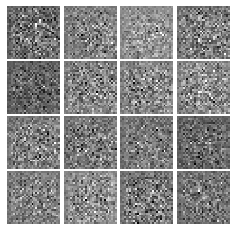


Iter: 0, D: 5.999, G:5.298
Accuracy: 0.109375
Iter: 50, D: 5.563, G:6.588
Accuracy: 0.1171875
Iter: 100, D: 4.75, G:8.198
Accuracy: 0.09375
Iter: 150, D: 4.818, G:7.078
Accuracy: 0.07421875
Iter: 200, D: 4.926, G:7.057
Accuracy: 0.07421875


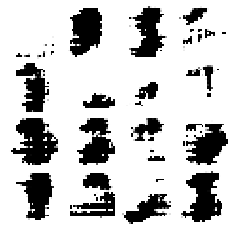


Iter: 250, D: 4.682, G:8.376
Accuracy: 0.109375
Iter: 300, D: 6.829, G:4.876
Accuracy: 0.10546875
Iter: 350, D: 4.703, G:8.024
Accuracy: 0.08984375
Iter: 400, D: 5.724, G:6.301
Accuracy: 0.09375
Iter: 450, D: 5.94, G:5.35
Accuracy: 0.11328125


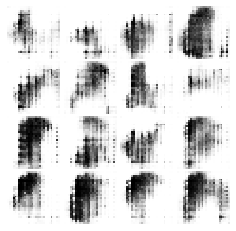


Iter: 500, D: 5.982, G:5.283
Accuracy: 0.0859375
Iter: 550, D: 5.792, G:5.518
Accuracy: 0.078125
Iter: 600, D: 5.937, G:5.457
Accuracy: 0.1015625
Iter: 650, D: 5.898, G:5.313
Accuracy: 0.08203125
Iter: 700, D: 5.76, G:5.481
Accuracy: 0.125


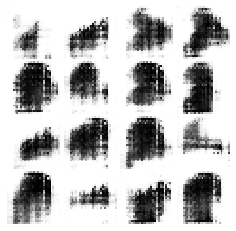


Iter: 750, D: 5.953, G:5.359
Accuracy: 0.10546875
Iter: 800, D: 5.811, G:5.438
Accuracy: 0.0859375
Iter: 850, D: 5.668, G:5.635
Accuracy: 0.1015625
Iter: 900, D: 5.828, G:5.358
Accuracy: 0.078125
Iter: 950, D: 6.072, G:5.353
Accuracy: 0.09765625


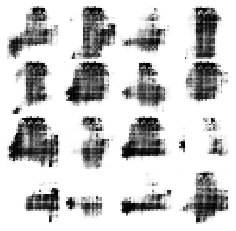


Iter: 1000, D: 5.76, G:5.425
Accuracy: 0.109375
Iter: 1050, D: 5.545, G:5.62
Accuracy: 0.09765625
Iter: 1100, D: 5.984, G:5.304
Accuracy: 0.0859375
Iter: 1150, D: 5.945, G:5.38
Accuracy: 0.06640625
Iter: 1200, D: 5.561, G:5.841
Accuracy: 0.125


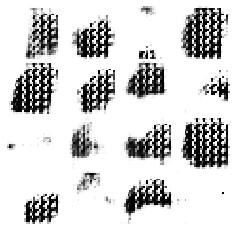


Iter: 1250, D: 5.371, G:6.33
Accuracy: 0.11328125
Iter: 1300, D: 5.917, G:5.588
Accuracy: 0.1171875
Iter: 1350, D: 5.642, G:5.583
Accuracy: 0.1171875
Iter: 1400, D: 5.845, G:5.493
Accuracy: 0.1171875
Iter: 1450, D: 5.106, G:6.096
Accuracy: 0.078125


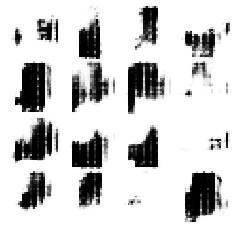


Iter: 1500, D: 5.611, G:5.655
Accuracy: 0.1171875
Iter: 1550, D: 5.512, G:5.823
Accuracy: 0.1015625
Iter: 1600, D: 5.435, G:5.712
Accuracy: 0.12109375
Iter: 1650, D: 5.616, G:5.924
Accuracy: 0.0859375
Iter: 1700, D: 5.43, G:5.994
Accuracy: 0.109375


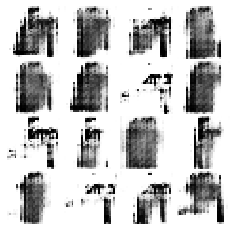


Iter: 1750, D: 5.482, G:5.804
Accuracy: 0.10546875
Iter: 1800, D: 5.599, G:5.868
Accuracy: 0.09375
Iter: 1850, D: 5.829, G:5.72
Accuracy: 0.0859375
Iter: 1900, D: 5.342, G:6.176
Accuracy: 0.09375
Iter: 1950, D: 6.405, G:4.926
Accuracy: 0.09375


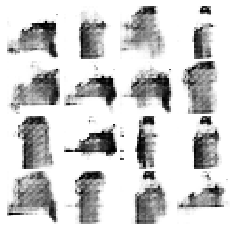


Iter: 2000, D: 5.652, G:5.467
Accuracy: 0.08984375
Iter: 2050, D: 5.416, G:5.901
Accuracy: 0.13671875
Iter: 2100, D: 5.885, G:5.569
Accuracy: 0.08984375
Iter: 2150, D: 5.673, G:5.876
Accuracy: 0.08984375
Iter: 2200, D: 5.482, G:5.927
Accuracy: 0.09375


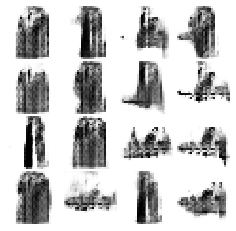


Iter: 2250, D: 5.388, G:6.316
Accuracy: 0.10546875
Iter: 2300, D: 5.321, G:6.104
Accuracy: 0.140625
Iter: 2350, D: 5.309, G:6.259
Accuracy: 0.1015625
Iter: 2400, D: 5.912, G:6.315
Accuracy: 0.125
Iter: 2450, D: 5.254, G:6.411
Accuracy: 0.078125


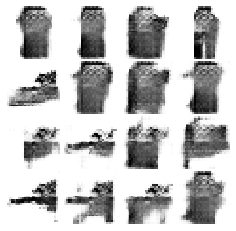


Iter: 2500, D: 5.488, G:5.685
Accuracy: 0.08984375
Iter: 2550, D: 5.551, G:5.793
Accuracy: 0.12109375
Iter: 2600, D: 5.217, G:6.055
Accuracy: 0.0859375
Iter: 2650, D: 5.501, G:5.823
Accuracy: 0.109375
Iter: 2700, D: 5.557, G:5.607
Accuracy: 0.125


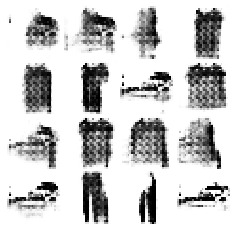


Iter: 2750, D: 5.174, G:6.374
Accuracy: 0.0625
Iter: 2800, D: 5.593, G:5.714
Accuracy: 0.05078125
Iter: 2850, D: 5.527, G:6.162
Accuracy: 0.0859375
Iter: 2900, D: 5.511, G:5.794
Accuracy: 0.1015625
Iter: 2950, D: 5.545, G:5.743
Accuracy: 0.0859375


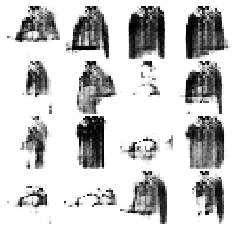


Iter: 3000, D: 5.929, G:5.548
Accuracy: 0.08984375
Iter: 3050, D: 5.36, G:6.368
Accuracy: 0.0625
Iter: 3100, D: 5.559, G:6.821
Accuracy: 0.11328125
Iter: 3150, D: 5.395, G:5.951
Accuracy: 0.125
Iter: 3200, D: 5.687, G:6.155
Accuracy: 0.10546875


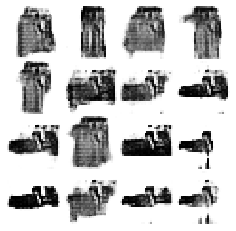


Iter: 3250, D: 5.551, G:6.077
Accuracy: 0.08984375
Iter: 3300, D: 5.516, G:6.197
Accuracy: 0.0859375
Iter: 3350, D: 5.407, G:5.906
Accuracy: 0.09765625
Iter: 3400, D: 5.442, G:6.153
Accuracy: 0.08203125
Iter: 3450, D: 5.192, G:6.549
Accuracy: 0.09375


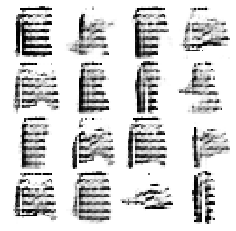


Iter: 3500, D: 5.096, G:6.735
Accuracy: 0.0859375
Iter: 3550, D: 5.91, G:6.114
Accuracy: 0.10546875
Iter: 3600, D: 5.513, G:7.801
Accuracy: 0.09765625
Iter: 3650, D: 5.531, G:5.348
Accuracy: 0.125
Iter: 3700, D: 5.435, G:5.828
Accuracy: 0.1171875


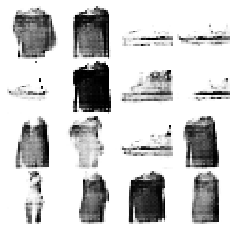


Iter: 3750, D: 5.467, G:5.951
Accuracy: 0.10546875
Iter: 3800, D: 5.322, G:5.954
Accuracy: 0.12109375
Iter: 3850, D: 5.431, G:5.8
Accuracy: 0.1015625
Iter: 3900, D: 5.33, G:6.246
Accuracy: 0.12109375
Iter: 3950, D: 5.237, G:6.201
Accuracy: 0.08984375


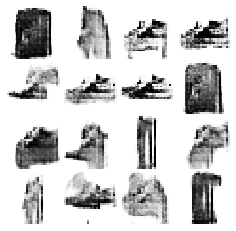


Iter: 4000, D: 5.283, G:6.078
Accuracy: 0.109375
Iter: 4050, D: 5.534, G:5.98
Accuracy: 0.09375
Iter: 4100, D: 5.552, G:6.043
Accuracy: 0.1015625
Iter: 4150, D: 5.801, G:5.308
Accuracy: 0.125
Iter: 4200, D: 5.325, G:6.328
Accuracy: 0.08984375


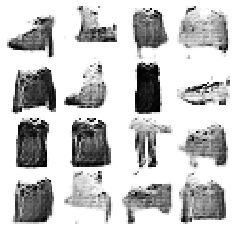


Iter: 4250, D: 5.82, G:5.694
Accuracy: 0.0859375
Iter: 4300, D: 5.49, G:5.712
Accuracy: 0.09765625
Iter: 4350, D: 5.442, G:6.111
Accuracy: 0.09375
Iter: 4400, D: 5.58, G:5.417
Accuracy: 0.12890625
Iter: 4450, D: 5.598, G:5.441
Accuracy: 0.125


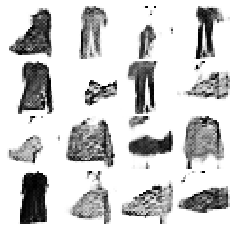


Iter: 4500, D: 5.511, G:5.557
Accuracy: 0.10546875
Iter: 4550, D: 5.728, G:5.271
Accuracy: 0.09375
Iter: 4600, D: 5.421, G:6.006
Accuracy: 0.09375
Iter: 4650, D: 5.589, G:5.499
Accuracy: 0.09375
Iter: 4700, D: 5.753, G:5.644
Accuracy: 0.08203125


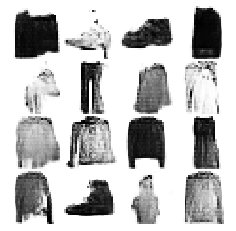


Iter: 4750, D: 5.536, G:5.754
Accuracy: 0.08203125
Iter: 4800, D: 5.678, G:5.517
Accuracy: 0.12109375
Iter: 4850, D: 5.478, G:5.999
Accuracy: 0.11328125
Iter: 4900, D: 5.943, G:6.495
Accuracy: 0.11328125
Iter: 4950, D: 5.746, G:5.894
Accuracy: 0.1015625


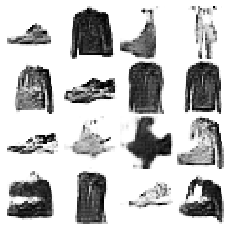


Iter: 5000, D: 5.625, G:5.716
Accuracy: 0.1171875
Iter: 5050, D: 5.728, G:6.157
Accuracy: 0.11328125
Iter: 5100, D: 5.799, G:5.864
Accuracy: 0.08203125
Iter: 5150, D: 5.59, G:5.838
Accuracy: 0.09765625
Iter: 5200, D: 6.077, G:5.131
Accuracy: 0.1171875


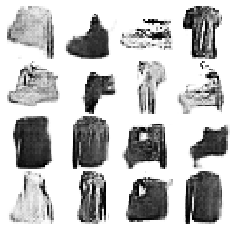


Iter: 5250, D: 5.449, G:5.965
Accuracy: 0.140625
Iter: 5300, D: 5.638, G:5.676
Accuracy: 0.09765625
Iter: 5350, D: 5.671, G:5.82
Accuracy: 0.12890625
Iter: 5400, D: 5.479, G:6.175
Accuracy: 0.0859375
Iter: 5450, D: 5.559, G:6.086
Accuracy: 0.08984375


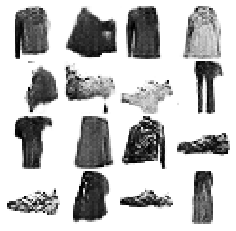


Iter: 5500, D: 5.643, G:6.077
Accuracy: 0.09375
Iter: 5550, D: 5.665, G:5.863
Accuracy: 0.07421875
Iter: 5600, D: 5.561, G:5.609
Accuracy: 0.1015625
Iter: 5650, D: 5.604, G:6.088
Accuracy: 0.11328125
Iter: 5700, D: 5.699, G:5.622
Accuracy: 0.1484375


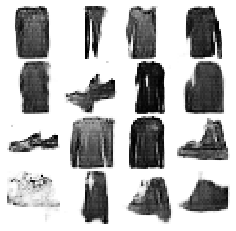


Iter: 5750, D: 5.538, G:5.699
Accuracy: 0.08203125
Iter: 5800, D: 5.634, G:5.882
Accuracy: 0.12890625
Iter: 5850, D: 5.68, G:5.892
Accuracy: 0.08203125
Iter: 5900, D: 5.692, G:5.569
Accuracy: 0.12890625
Iter: 5950, D: 5.509, G:6.518
Accuracy: 0.0859375


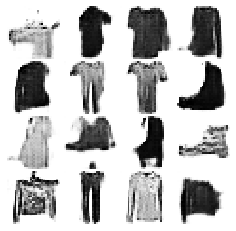


Iter: 6000, D: 5.563, G:6.012
Accuracy: 0.10546875
Iter: 6050, D: 5.684, G:5.524
Accuracy: 0.09375
Iter: 6100, D: 5.63, G:6.209
Accuracy: 0.1171875
Iter: 6150, D: 5.575, G:5.685
Accuracy: 0.11328125
Iter: 6200, D: 4.896, G:8.649
Accuracy: 0.08203125


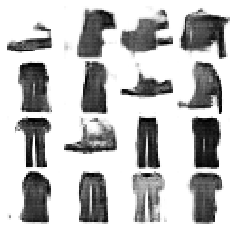


Iter: 6250, D: 5.511, G:5.7
Accuracy: 0.078125
Iter: 6300, D: 5.41, G:6.329
Accuracy: 0.11328125
Iter: 6350, D: 5.591, G:5.822
Accuracy: 0.078125
Iter: 6400, D: 5.449, G:5.706
Accuracy: 0.10546875
Iter: 6450, D: 5.613, G:5.634
Accuracy: 0.125


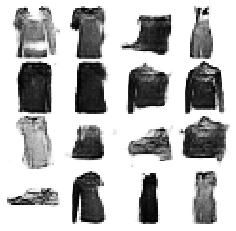


Iter: 6500, D: 5.617, G:6.103
Accuracy: 0.08984375
Iter: 6550, D: 5.62, G:5.776
Accuracy: 0.0859375
Iter: 6600, D: 5.526, G:5.572
Accuracy: 0.1015625
Iter: 6650, D: 5.72, G:5.896
Accuracy: 0.07421875
Iter: 6700, D: 5.804, G:6.073
Accuracy: 0.1328125


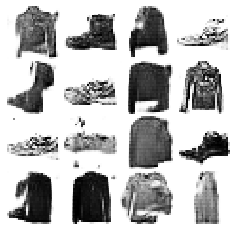


Iter: 6750, D: 5.683, G:5.896
Accuracy: 0.09765625
Iter: 6800, D: 5.633, G:5.652
Accuracy: 0.078125
Iter: 6850, D: 5.778, G:6.049
Accuracy: 0.09765625
Iter: 6900, D: 5.683, G:5.962
Accuracy: 0.1328125
Iter: 6950, D: 5.682, G:5.81
Accuracy: 0.125


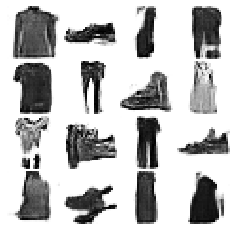


Iter: 7000, D: 5.83, G:5.985
Accuracy: 0.0625
Iter: 7050, D: 5.609, G:5.907
Accuracy: 0.11328125
Iter: 7100, D: 5.654, G:5.306
Accuracy: 0.1171875
Iter: 7150, D: 5.688, G:5.728
Accuracy: 0.09765625
Iter: 7200, D: 5.703, G:5.972
Accuracy: 0.09375


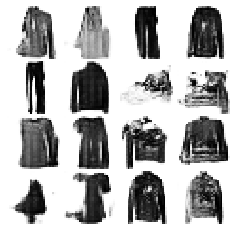


Iter: 7250, D: 5.757, G:5.952
Accuracy: 0.09765625
Iter: 7300, D: 5.732, G:5.556
Accuracy: 0.09765625
Iter: 7350, D: 5.813, G:5.768
Accuracy: 0.15234375
Iter: 7400, D: 5.749, G:5.323
Accuracy: 0.1171875
Iter: 7450, D: 5.774, G:5.343
Accuracy: 0.1328125


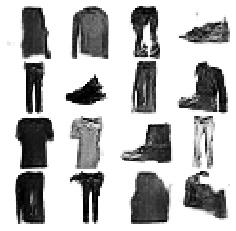


Iter: 7500, D: 5.519, G:6.11
Accuracy: 0.11328125
Iter: 7550, D: 5.856, G:5.994
Accuracy: 0.11328125
Iter: 7600, D: 5.645, G:5.687
Accuracy: 0.1328125
Iter: 7650, D: 5.764, G:6.261
Accuracy: 0.11328125
Iter: 7700, D: 5.861, G:5.643
Accuracy: 0.0859375


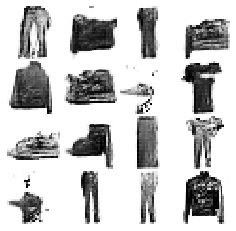


Iter: 7750, D: 5.673, G:5.832
Accuracy: 0.10546875
Iter: 7800, D: 5.713, G:5.7
Accuracy: 0.11328125
Iter: 7850, D: 5.795, G:5.529
Accuracy: 0.0859375
Iter: 7900, D: 5.777, G:5.78
Accuracy: 0.11328125
Iter: 7950, D: 5.608, G:5.68
Accuracy: 0.09765625


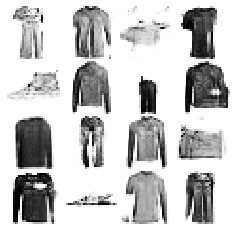


Iter: 8000, D: 5.788, G:5.401
Accuracy: 0.08984375
Iter: 8050, D: 5.754, G:6.101
Accuracy: 0.09375
Iter: 8100, D: 5.526, G:5.809
Accuracy: 0.109375
Iter: 8150, D: 5.73, G:5.402
Accuracy: 0.12109375
Iter: 8200, D: 5.652, G:5.561
Accuracy: 0.09765625


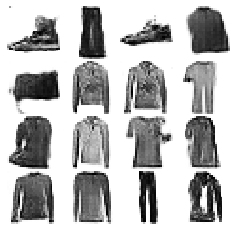


Iter: 8250, D: 5.632, G:5.917
Accuracy: 0.0703125
Iter: 8300, D: 5.675, G:5.593
Accuracy: 0.1171875
Iter: 8350, D: 5.345, G:6.576
Accuracy: 0.09765625
Iter: 8400, D: 5.56, G:5.695
Accuracy: 0.12890625
Iter: 8450, D: 5.578, G:5.846
Accuracy: 0.1328125


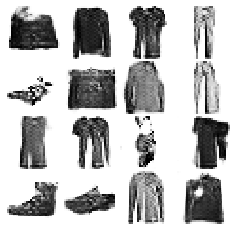


Iter: 8500, D: 5.553, G:5.611
Accuracy: 0.125
Iter: 8550, D: 5.648, G:5.454
Accuracy: 0.125
Iter: 8600, D: 5.492, G:5.616
Accuracy: 0.0703125
Iter: 8650, D: 5.706, G:5.553
Accuracy: 0.09765625
Iter: 8700, D: 5.632, G:5.731
Accuracy: 0.12109375


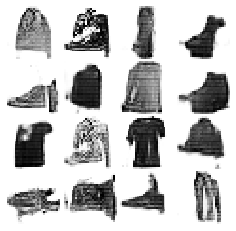


Iter: 8750, D: 5.463, G:5.937
Accuracy: 0.10546875
Iter: 8800, D: 5.617, G:5.539
Accuracy: 0.13671875
Iter: 8850, D: 5.645, G:5.958
Accuracy: 0.09765625
Iter: 8900, D: 5.852, G:5.255
Accuracy: 0.07421875
Iter: 8950, D: 5.749, G:5.642
Accuracy: 0.1015625


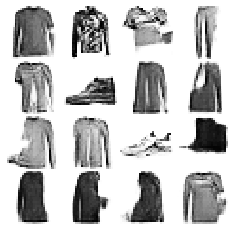


Iter: 9000, D: 5.734, G:5.608
Accuracy: 0.09765625
Iter: 9050, D: 5.68, G:5.451
Accuracy: 0.07421875
Iter: 9100, D: 5.769, G:5.614
Accuracy: 0.109375
Iter: 9150, D: 5.735, G:5.803
Accuracy: 0.06640625
Iter: 9200, D: 5.749, G:5.686
Accuracy: 0.0859375


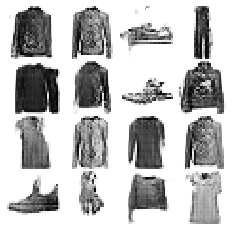


Iter: 9250, D: 5.947, G:5.947
Accuracy: 0.1015625
Iter: 9300, D: 5.599, G:5.745
Accuracy: 0.07421875
Iter: 9350, D: 5.785, G:6.261
Accuracy: 0.12890625
Iter: 9400, D: 5.666, G:5.374
Accuracy: 0.07421875
Iter: 9450, D: 5.777, G:5.222
Accuracy: 0.09765625


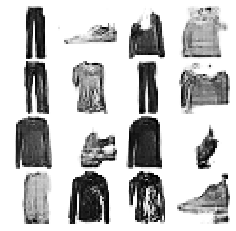


Iter: 9500, D: 5.625, G:5.769
Accuracy: 0.10546875
Iter: 9550, D: 5.726, G:5.758
Accuracy: 0.140625
Iter: 9600, D: 5.61, G:5.751
Accuracy: 0.06640625
Iter: 9650, D: 5.688, G:5.512
Accuracy: 0.1171875
Iter: 9700, D: 5.731, G:5.882
Accuracy: 0.11328125


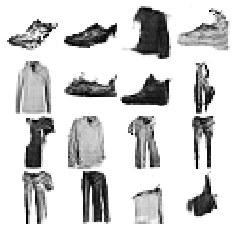


Iter: 9750, D: 5.686, G:5.864
Accuracy: 0.1171875
Iter: 9800, D: 5.744, G:5.433
Accuracy: 0.109375
Iter: 9850, D: 5.877, G:5.278
Accuracy: 0.1328125
Iter: 9900, D: 5.926, G:5.205
Accuracy: 0.125
Iter: 9950, D: 5.846, G:6.017
Accuracy: 0.08984375


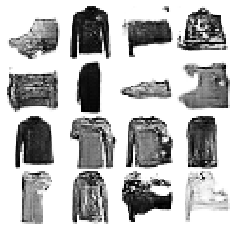


Iter: 10000, D: 5.653, G:5.582
Accuracy: 0.109375
Iter: 10050, D: 5.818, G:5.509
Accuracy: 0.0859375
Iter: 10100, D: 5.705, G:5.772
Accuracy: 0.140625
Iter: 10150, D: 5.76, G:5.738
Accuracy: 0.08984375
Iter: 10200, D: 5.754, G:5.609
Accuracy: 0.0703125


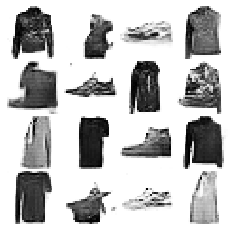


Iter: 10250, D: 5.786, G:5.617
Accuracy: 0.0859375
Iter: 10300, D: 5.784, G:5.512
Accuracy: 0.07421875
Iter: 10350, D: 5.682, G:5.778
Accuracy: 0.09765625
Iter: 10400, D: 5.604, G:5.433
Accuracy: 0.078125
Iter: 10450, D: 5.837, G:5.585
Accuracy: 0.09765625


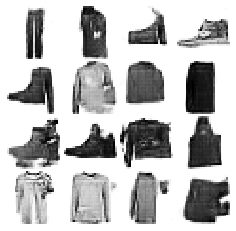


Iter: 10500, D: 5.704, G:5.502
Accuracy: 0.109375
Iter: 10550, D: 5.668, G:5.824
Accuracy: 0.07421875
Iter: 10600, D: 5.753, G:5.609
Accuracy: 0.09765625
Iter: 10650, D: 5.76, G:5.87
Accuracy: 0.13671875
Iter: 10700, D: 5.955, G:5.111
Accuracy: 0.11328125


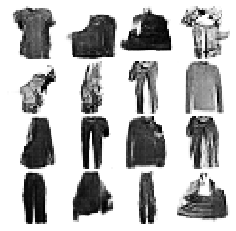


Iter: 10750, D: 5.628, G:5.667
Accuracy: 0.08984375
Iter: 10800, D: 5.829, G:5.549
Accuracy: 0.06640625
Iter: 10850, D: 5.717, G:5.876
Accuracy: 0.109375
Iter: 10900, D: 5.658, G:5.637
Accuracy: 0.09765625
Iter: 10950, D: 5.742, G:6.221
Accuracy: 0.10546875


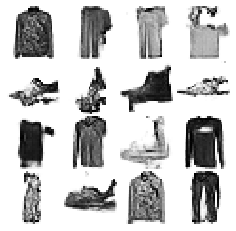


Iter: 11000, D: 5.802, G:5.559
Accuracy: 0.06640625
Iter: 11050, D: 5.724, G:5.696
Accuracy: 0.109375
Iter: 11100, D: 5.881, G:5.45
Accuracy: 0.109375
Iter: 11150, D: 5.774, G:6.111
Accuracy: 0.06640625
Iter: 11200, D: 5.696, G:5.656
Accuracy: 0.12109375


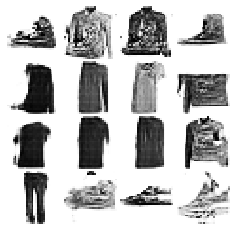


Iter: 11250, D: 5.664, G:5.616
Accuracy: 0.1328125
Iter: 11300, D: 5.548, G:5.783
Accuracy: 0.09765625
Iter: 11350, D: 5.671, G:5.976
Accuracy: 0.10546875
Iter: 11400, D: 5.708, G:5.646
Accuracy: 0.06640625
Iter: 11450, D: 5.764, G:5.326
Accuracy: 0.078125


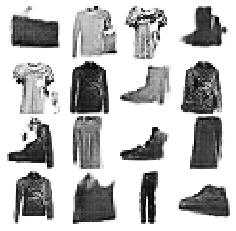


Iter: 11500, D: 5.564, G:5.79
Accuracy: 0.140625
Iter: 11550, D: 5.667, G:5.762
Accuracy: 0.109375
Iter: 11600, D: 5.677, G:5.711
Accuracy: 0.1171875
Iter: 11650, D: 5.691, G:5.669
Accuracy: 0.1484375
Iter: 11700, D: 5.715, G:5.697
Accuracy: 0.08984375


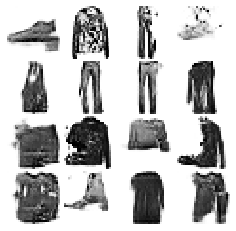


Iter: 11750, D: 5.865, G:5.437
Accuracy: 0.078125
Iter: 11800, D: 5.664, G:5.383
Accuracy: 0.08203125
Iter: 11850, D: 5.624, G:5.773
Accuracy: 0.11328125
Iter: 11900, D: 5.665, G:5.404
Accuracy: 0.09375
Iter: 11950, D: 5.746, G:5.55
Accuracy: 0.07421875


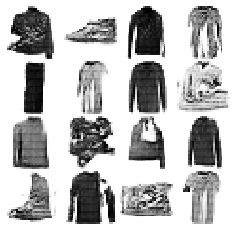


Iter: 12000, D: 5.534, G:5.977
Accuracy: 0.10546875
Iter: 12050, D: 5.705, G:5.538
Accuracy: 0.109375
Iter: 12100, D: 5.655, G:5.594
Accuracy: 0.1015625
Iter: 12150, D: 5.719, G:5.583
Accuracy: 0.11328125
Iter: 12200, D: 5.319, G:6.464
Accuracy: 0.07421875


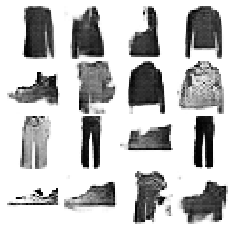


Iter: 12250, D: 5.71, G:5.56
Accuracy: 0.12109375
Iter: 12300, D: 5.29, G:6.571
Accuracy: 0.1015625
Iter: 12350, D: 5.563, G:6.107
Accuracy: 0.08984375
Iter: 12400, D: 5.827, G:5.71
Accuracy: 0.1015625
Iter: 12450, D: 5.803, G:6.252
Accuracy: 0.0703125


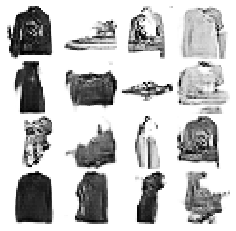


Iter: 12500, D: 5.679, G:5.65
Accuracy: 0.13671875
Iter: 12550, D: 5.578, G:5.594
Accuracy: 0.109375
Iter: 12600, D: 5.791, G:6.169
Accuracy: 0.08984375
Iter: 12650, D: 5.639, G:5.762
Accuracy: 0.1171875
Iter: 12700, D: 5.791, G:5.283
Accuracy: 0.1015625


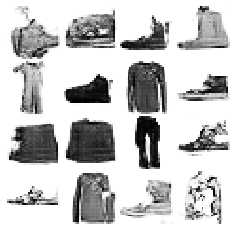


Iter: 12750, D: 5.708, G:5.642
Accuracy: 0.12890625
Iter: 12800, D: 5.97, G:6.293
Accuracy: 0.109375
Iter: 12850, D: 5.927, G:5.3
Accuracy: 0.1171875
Iter: 12900, D: 5.756, G:6.06
Accuracy: 0.1328125
Iter: 12950, D: 5.677, G:5.636
Accuracy: 0.1015625


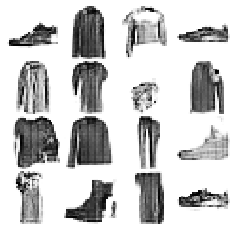


Iter: 13000, D: 5.667, G:5.919
Accuracy: 0.10546875
Iter: 13050, D: 5.616, G:5.559
Accuracy: 0.078125
Iter: 13100, D: 5.774, G:5.891
Accuracy: 0.078125
Iter: 13150, D: 5.656, G:5.836
Accuracy: 0.07421875
Iter: 13200, D: 5.656, G:5.621
Accuracy: 0.10546875


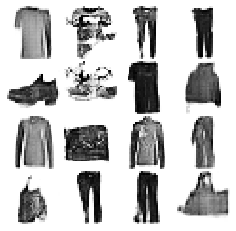


Iter: 13250, D: 5.68, G:6.035
Accuracy: 0.09375
Iter: 13300, D: 5.714, G:5.585
Accuracy: 0.10546875
Iter: 13350, D: 5.736, G:5.772
Accuracy: 0.0859375
Iter: 13400, D: 5.883, G:5.699
Accuracy: 0.078125
Iter: 13450, D: 5.811, G:6.027
Accuracy: 0.09375


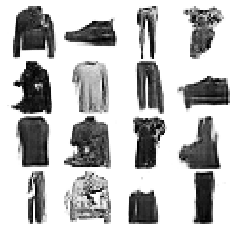


Iter: 13500, D: 5.755, G:5.376
Accuracy: 0.140625
Iter: 13550, D: 5.663, G:5.934
Accuracy: 0.1015625
Iter: 13600, D: 5.732, G:6.014
Accuracy: 0.11328125
Iter: 13650, D: 5.741, G:5.513
Accuracy: 0.1015625
Iter: 13700, D: 5.717, G:5.295
Accuracy: 0.0625


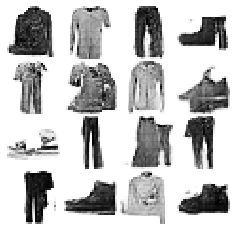


Iter: 13750, D: 5.774, G:5.927
Accuracy: 0.11328125
Iter: 13800, D: 5.836, G:5.505
Accuracy: 0.109375
Iter: 13850, D: 5.829, G:5.457
Accuracy: 0.10546875
Iter: 13900, D: 5.971, G:5.804
Accuracy: 0.1328125
Iter: 13950, D: 5.746, G:5.514
Accuracy: 0.109375


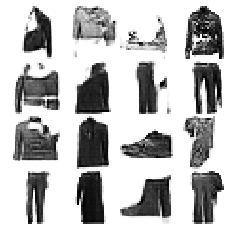


Iter: 14000, D: 5.691, G:5.711
Accuracy: 0.06640625
Iter: 14050, D: 5.827, G:5.722
Accuracy: 0.1015625
Iter: 14100, D: 5.891, G:5.732
Accuracy: 0.0859375
Iter: 14150, D: 5.67, G:5.771
Accuracy: 0.09375
Iter: 14200, D: 5.739, G:5.501
Accuracy: 0.0859375


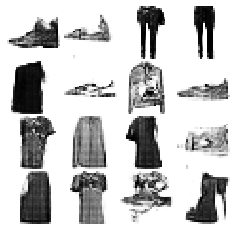


Iter: 14250, D: 5.638, G:5.507
Accuracy: 0.09375
Iter: 14300, D: 5.721, G:5.877
Accuracy: 0.08203125
Iter: 14350, D: 5.916, G:5.856
Accuracy: 0.0859375
Iter: 14400, D: 5.697, G:5.704
Accuracy: 0.1171875
Iter: 14450, D: 5.847, G:5.586
Accuracy: 0.140625


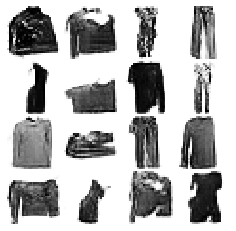


Iter: 14500, D: 5.787, G:5.617
Accuracy: 0.109375
Iter: 14550, D: 5.749, G:5.856
Accuracy: 0.08203125
Iter: 14600, D: 5.887, G:5.235
Accuracy: 0.09375
Iter: 14650, D: 5.837, G:5.404
Accuracy: 0.1015625
Iter: 14700, D: 5.649, G:5.489
Accuracy: 0.1171875


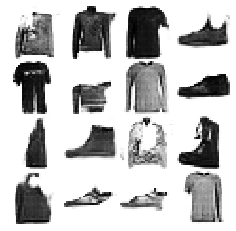


Iter: 14750, D: 5.662, G:5.57
Accuracy: 0.08203125
Iter: 14800, D: 5.848, G:5.855
Accuracy: 0.13671875
Iter: 14850, D: 5.867, G:5.463
Accuracy: 0.12890625
Iter: 14900, D: 5.891, G:5.594
Accuracy: 0.1328125
Iter: 14950, D: 5.752, G:5.62
Accuracy: 0.11328125


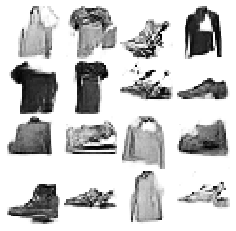


Iter: 15000, D: 5.759, G:5.4
Accuracy: 0.109375
Iter: 15050, D: 5.638, G:5.426
Accuracy: 0.09765625
Iter: 15100, D: 5.628, G:5.663
Accuracy: 0.0859375
Iter: 15150, D: 5.715, G:5.546
Accuracy: 0.109375
Iter: 15200, D: 5.667, G:5.294
Accuracy: 0.0859375


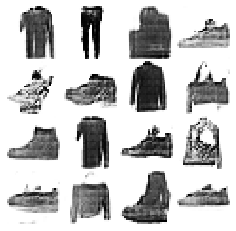


Iter: 15250, D: 5.689, G:5.926
Accuracy: 0.109375
Iter: 15300, D: 5.832, G:5.95
Accuracy: 0.1015625
Iter: 15350, D: 5.676, G:5.461
Accuracy: 0.08984375
Iter: 15400, D: 5.748, G:5.608
Accuracy: 0.11328125
Iter: 15450, D: 5.683, G:5.584
Accuracy: 0.10546875


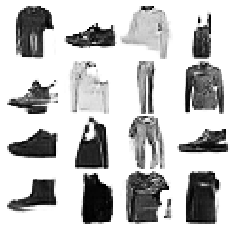


Iter: 15500, D: 5.78, G:5.695
Accuracy: 0.08984375
Iter: 15550, D: 5.699, G:5.794
Accuracy: 0.0703125
Iter: 15600, D: 6.072, G:6.424
Accuracy: 0.1015625
Iter: 15650, D: 5.265, G:6.511
Accuracy: 0.09375
Iter: 15700, D: 5.239, G:7.298
Accuracy: 0.1171875


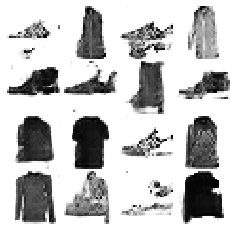


Iter: 15750, D: 5.563, G:5.909
Accuracy: 0.10546875
Iter: 15800, D: 5.622, G:6.01
Accuracy: 0.0859375
Iter: 15850, D: 5.558, G:5.816
Accuracy: 0.1015625
Iter: 15900, D: 5.703, G:5.344
Accuracy: 0.09765625
Iter: 15950, D: 5.738, G:5.561
Accuracy: 0.07421875


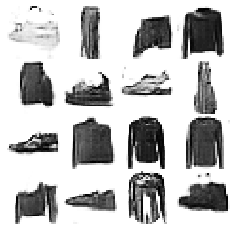


Iter: 16000, D: 5.684, G:5.521
Accuracy: 0.08984375
Iter: 16050, D: 5.62, G:6.384
Accuracy: 0.10546875
Iter: 16100, D: 5.587, G:5.63
Accuracy: 0.1015625
Iter: 16150, D: 5.679, G:5.492
Accuracy: 0.08203125
Iter: 16200, D: 5.711, G:5.466
Accuracy: 0.08203125


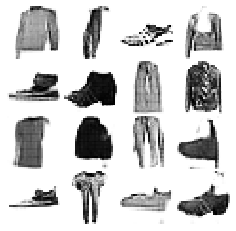


Iter: 16250, D: 5.751, G:5.422
Accuracy: 0.13671875
Iter: 16300, D: 5.593, G:5.502
Accuracy: 0.08984375
Iter: 16350, D: 5.701, G:5.692
Accuracy: 0.1015625
Iter: 16400, D: 5.69, G:5.715
Accuracy: 0.08203125
Iter: 16450, D: 5.893, G:5.815
Accuracy: 0.08984375


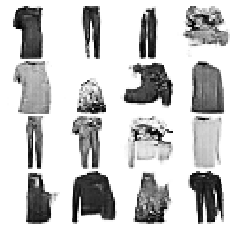


Iter: 16500, D: 5.816, G:5.636
Accuracy: 0.09375
Iter: 16550, D: 5.733, G:5.382
Accuracy: 0.10546875
Iter: 16600, D: 5.769, G:5.849
Accuracy: 0.10546875
Iter: 16650, D: 5.822, G:5.591
Accuracy: 0.0859375
Iter: 16700, D: 5.757, G:5.939
Accuracy: 0.09765625


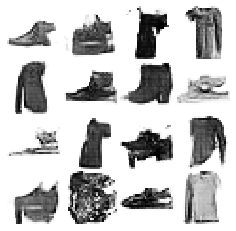


Iter: 16750, D: 5.604, G:5.742
Accuracy: 0.0859375
Iter: 16800, D: 5.744, G:5.773
Accuracy: 0.08984375
Iter: 16850, D: 5.636, G:5.421
Accuracy: 0.08984375
Iter: 16900, D: 5.724, G:5.74
Accuracy: 0.08203125
Iter: 16950, D: 5.853, G:5.466
Accuracy: 0.10546875


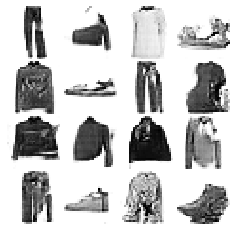


Iter: 17000, D: 5.626, G:5.737
Accuracy: 0.0859375
Iter: 17050, D: 5.697, G:5.601
Accuracy: 0.0859375
Iter: 17100, D: 5.737, G:5.969
Accuracy: 0.1015625
Iter: 17150, D: 5.696, G:5.783
Accuracy: 0.1328125
Iter: 17200, D: 5.722, G:5.855
Accuracy: 0.06640625


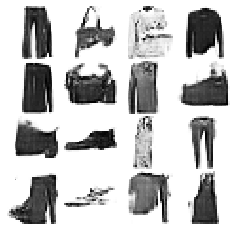


Iter: 17250, D: 5.748, G:5.56
Accuracy: 0.10546875
Iter: 17300, D: 5.776, G:5.732
Accuracy: 0.07421875
Iter: 17350, D: 5.764, G:5.427
Accuracy: 0.09765625
Iter: 17400, D: 5.786, G:5.982
Accuracy: 0.1015625
Iter: 17450, D: 5.691, G:5.469
Accuracy: 0.07421875


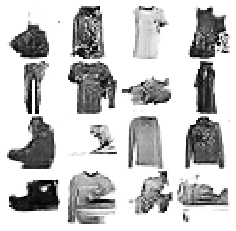


Iter: 17500, D: 5.715, G:5.517
Accuracy: 0.08203125
Iter: 17550, D: 5.745, G:5.349
Accuracy: 0.06640625
Iter: 17600, D: 5.773, G:5.817
Accuracy: 0.109375
Iter: 17650, D: 5.716, G:5.465
Accuracy: 0.07421875
Iter: 17700, D: 5.775, G:5.558
Accuracy: 0.0625


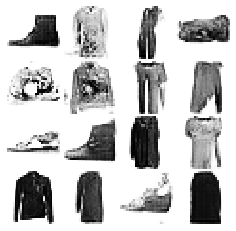


Iter: 17750, D: 5.776, G:5.602
Accuracy: 0.0859375
Iter: 17800, D: 5.764, G:5.561
Accuracy: 0.0703125
Iter: 17850, D: 5.949, G:5.606
Accuracy: 0.078125
Iter: 17900, D: 5.831, G:5.633
Accuracy: 0.08203125
Iter: 17950, D: 5.767, G:5.629
Accuracy: 0.125


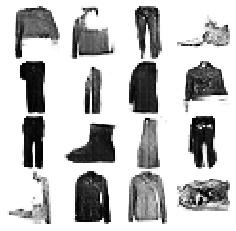


Iter: 18000, D: 5.817, G:5.41
Accuracy: 0.09375
Iter: 18050, D: 5.848, G:5.801
Accuracy: 0.08203125
Iter: 18100, D: 5.794, G:5.601
Accuracy: 0.12109375
Iter: 18150, D: 5.857, G:5.393
Accuracy: 0.1328125
Iter: 18200, D: 5.69, G:5.608
Accuracy: 0.109375


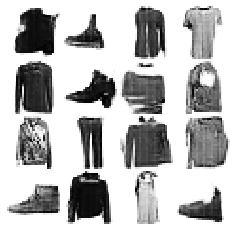


Iter: 18250, D: 5.708, G:5.541
Accuracy: 0.09765625
Iter: 18300, D: 5.721, G:5.374
Accuracy: 0.0859375
Iter: 18350, D: 5.784, G:5.377
Accuracy: 0.1015625
Iter: 18400, D: 5.778, G:5.738
Accuracy: 0.10546875
Iter: 18450, D: 5.677, G:5.486
Accuracy: 0.07421875


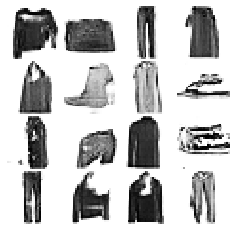


Iter: 18500, D: 5.698, G:5.663
Accuracy: 0.08984375
Iter: 18550, D: 5.89, G:5.944
Accuracy: 0.09765625
Iter: 18600, D: 5.75, G:5.609
Accuracy: 0.13671875
Iter: 18650, D: 5.776, G:5.38
Accuracy: 0.08984375
Iter: 18700, D: 5.807, G:5.486
Accuracy: 0.09375


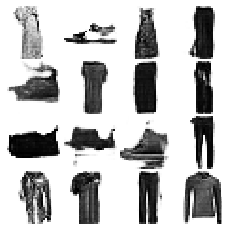


Iter: 18750, D: 5.768, G:5.785
Accuracy: 0.12109375
Iter: 18800, D: 5.893, G:5.176
Accuracy: 0.1171875
Iter: 18850, D: 5.734, G:5.378
Accuracy: 0.08984375
Iter: 18900, D: 5.744, G:5.537
Accuracy: 0.0859375
Iter: 18950, D: 5.548, G:5.454
Accuracy: 0.12109375


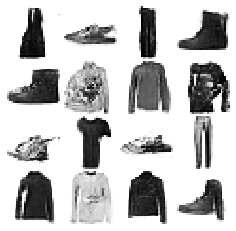


Iter: 19000, D: 5.741, G:5.42
Accuracy: 0.13671875
Iter: 19050, D: 5.812, G:5.409
Accuracy: 0.1015625
Iter: 19100, D: 5.745, G:5.425
Accuracy: 0.09765625
Iter: 19150, D: 5.713, G:5.754
Accuracy: 0.1171875
Iter: 19200, D: 5.716, G:5.762
Accuracy: 0.0859375


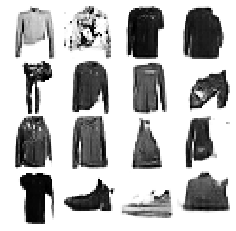


Iter: 19250, D: 5.812, G:5.37
Accuracy: 0.08203125
Iter: 19300, D: 5.604, G:5.634
Accuracy: 0.09765625
Iter: 19350, D: 5.864, G:5.258
Accuracy: 0.1015625
Iter: 19400, D: 5.67, G:5.496
Accuracy: 0.1328125
Iter: 19450, D: 5.789, G:5.431
Accuracy: 0.11328125


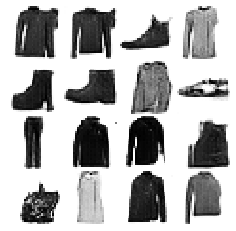


Iter: 19500, D: 5.697, G:5.567
Accuracy: 0.0859375
Iter: 19550, D: 5.799, G:5.409
Accuracy: 0.09375
Iter: 19600, D: 5.774, G:5.675
Accuracy: 0.1171875
Iter: 19650, D: 5.65, G:5.767
Accuracy: 0.08203125
Iter: 19700, D: 5.922, G:5.682
Accuracy: 0.078125


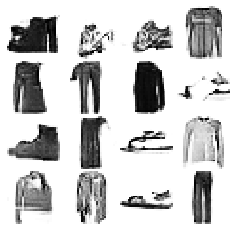


Iter: 19750, D: 5.859, G:5.722
Accuracy: 0.1015625
Iter: 19800, D: 5.712, G:6.06
Accuracy: 0.0859375
Iter: 19850, D: 5.504, G:5.786
Accuracy: 0.0546875
Iter: 19900, D: 5.584, G:5.704
Accuracy: 0.10546875
Iter: 19950, D: 5.668, G:5.847
Accuracy: 0.0859375


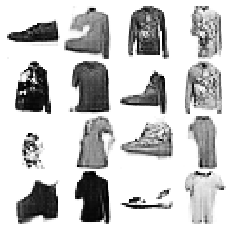


Iter: 20000, D: 5.585, G:5.706
Accuracy: 0.15234375
Iter: 20050, D: 5.71, G:5.827
Accuracy: 0.125
Iter: 20100, D: 5.797, G:5.42
Accuracy: 0.10546875
Iter: 20150, D: 5.77, G:5.871
Accuracy: 0.140625
Iter: 20200, D: 5.671, G:5.396
Accuracy: 0.07421875


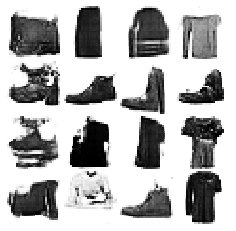


Iter: 20250, D: 5.723, G:5.406
Accuracy: 0.09765625
Iter: 20300, D: 5.732, G:5.738
Accuracy: 0.09765625
Iter: 20350, D: 5.838, G:5.562
Accuracy: 0.08984375
Iter: 20400, D: 5.789, G:6.081
Accuracy: 0.09765625
Iter: 20450, D: 5.826, G:5.451
Accuracy: 0.14453125


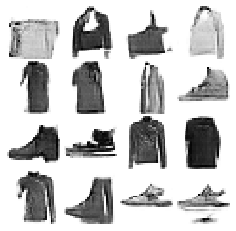


Iter: 20500, D: 5.787, G:5.482
Accuracy: 0.1015625
Iter: 20550, D: 5.756, G:5.656
Accuracy: 0.0859375
Iter: 20600, D: 5.837, G:5.363
Accuracy: 0.08984375
Iter: 20650, D: 5.767, G:5.422
Accuracy: 0.109375
Iter: 20700, D: 5.797, G:5.818
Accuracy: 0.1015625


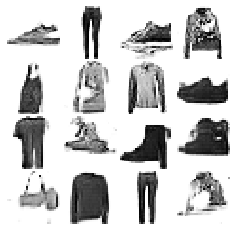


Iter: 20750, D: 5.702, G:5.489
Accuracy: 0.09375
Iter: 20800, D: 5.776, G:5.759
Accuracy: 0.10546875
Iter: 20850, D: 5.692, G:5.411
Accuracy: 0.08984375
Iter: 20900, D: 5.638, G:5.736
Accuracy: 0.10546875
Iter: 20950, D: 5.764, G:5.417
Accuracy: 0.109375


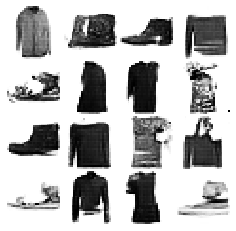


Iter: 21000, D: 5.618, G:5.791
Accuracy: 0.078125
Iter: 21050, D: 5.783, G:5.824
Accuracy: 0.08203125
Iter: 21100, D: 5.748, G:5.534
Accuracy: 0.12109375
Iter: 21150, D: 5.846, G:6.036
Accuracy: 0.10546875
Iter: 21200, D: 5.767, G:5.607
Accuracy: 0.09375


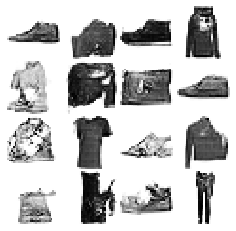


Iter: 21250, D: 5.775, G:5.454
Accuracy: 0.06640625
Iter: 21300, D: 5.808, G:5.207
Accuracy: 0.0859375
Iter: 21350, D: 5.895, G:5.684
Accuracy: 0.1328125
Iter: 21400, D: 5.745, G:5.523
Accuracy: 0.1171875
Iter: 21450, D: 5.856, G:5.4
Accuracy: 0.09375


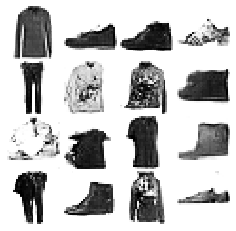


Iter: 21500, D: 5.74, G:5.791
Accuracy: 0.109375
Iter: 21550, D: 5.765, G:5.829
Accuracy: 0.09375
Iter: 21600, D: 5.75, G:5.472
Accuracy: 0.109375
Iter: 21650, D: 5.778, G:5.57
Accuracy: 0.09375
Iter: 21700, D: 5.754, G:5.835
Accuracy: 0.07421875


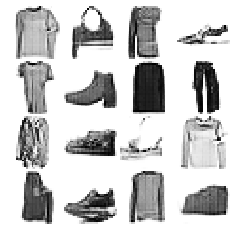


Iter: 21750, D: 5.741, G:5.402
Accuracy: 0.08984375
Iter: 21800, D: 5.664, G:5.532
Accuracy: 0.07421875
Iter: 21850, D: 5.824, G:5.755
Accuracy: 0.09765625
Iter: 21900, D: 5.732, G:5.458
Accuracy: 0.12890625
Iter: 21950, D: 5.788, G:5.476
Accuracy: 0.08984375


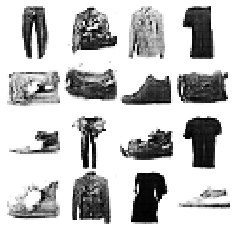


Iter: 22000, D: 5.693, G:5.356
Accuracy: 0.09375
Iter: 22050, D: 5.805, G:5.751
Accuracy: 0.09375
Iter: 22100, D: 5.843, G:5.794
Accuracy: 0.12890625
Iter: 22150, D: 5.502, G:5.834
Accuracy: 0.12890625
Iter: 22200, D: 5.558, G:5.979
Accuracy: 0.1171875


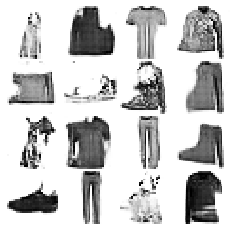


Iter: 22250, D: 5.679, G:5.568
Accuracy: 0.0703125
Iter: 22300, D: 5.623, G:5.767
Accuracy: 0.08984375
Iter: 22350, D: 5.673, G:5.478
Accuracy: 0.11328125
Iter: 22400, D: 5.938, G:6.435
Accuracy: 0.1015625
Iter: 22450, D: 5.721, G:5.653
Accuracy: 0.1015625


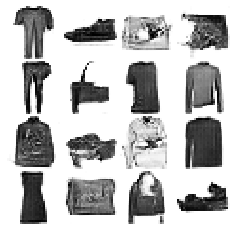


Iter: 22500, D: 5.841, G:5.571
Accuracy: 0.0859375
Iter: 22550, D: 5.321, G:6.017
Accuracy: 0.08984375
Iter: 22600, D: 5.726, G:5.444
Accuracy: 0.09765625
Iter: 22650, D: 5.745, G:5.418
Accuracy: 0.0859375
Iter: 22700, D: 5.763, G:5.76
Accuracy: 0.08984375


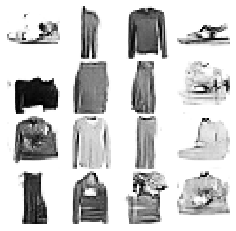


Iter: 22750, D: 5.755, G:5.547
Accuracy: 0.10546875
Iter: 22800, D: 5.778, G:5.56
Accuracy: 0.09375
Iter: 22850, D: 5.832, G:6.088
Accuracy: 0.1015625
Iter: 22900, D: 5.843, G:5.492
Accuracy: 0.12109375
Iter: 22950, D: 5.779, G:5.263
Accuracy: 0.109375


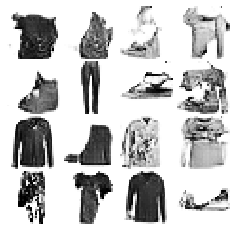


Iter: 23000, D: 5.826, G:5.233
Accuracy: 0.08984375
Iter: 23050, D: 5.728, G:5.447
Accuracy: 0.1015625
Iter: 23100, D: 5.794, G:5.422
Accuracy: 0.09765625
Iter: 23150, D: 5.803, G:5.326
Accuracy: 0.08203125
Iter: 23200, D: 5.751, G:5.647
Accuracy: 0.10546875


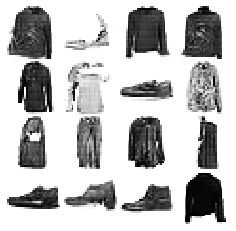


Iter: 23250, D: 5.657, G:5.781
Accuracy: 0.1484375
Iter: 23300, D: 5.779, G:5.562
Accuracy: 0.078125
Iter: 23350, D: 5.983, G:6.138
Accuracy: 0.08984375
Iter: 23400, D: 5.709, G:5.687
Accuracy: 0.1015625


ValueError: ignored

In [ ]:
# a giant helper function
def run_a_gan(show_every=250, print_every=50, batch_size=128, num_epoch=50):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    it = 0
    mnist1 = mnist.repeat(num_epoch).shuffle(batch_size).batch(batch_size, drop_remainder=True)
    batch_accuracies = []

    g_loss = []
    d_loss = []

    for minibatch in mnist1:
      minibatch_x = minibatch[0]
      minibatch_c = minibatch[1]

      # every show often, show a sample result
      if it % show_every == 0:
          z, _ = modified_sample_noise(batch_size, noise_dim, num_classes)
          samples = generator_model(z)
          fig = show_images(samples[:16])
          plt.show()
          print()
      # run a batch of data through the network
      G_loss_curr, D_loss_curr, batch_accuracy = train(minibatch_x, minibatch_c)
      batch_accuracies.append(batch_accuracy)

      # print loss every so often.
      # We want to make sure D_loss doesn't go to 0
      if it % print_every == 0:
          g_loss.append(G_loss_curr)
          d_loss.append(D_loss_curr)
          print('Iter: {}, D: {:.4}, G:{:.4}'.format(it, D_loss_curr, G_loss_curr))
          print('Accuracy: {}'.format(batch_accuracy))
      it += 1

    final_acc = tf.reduce_mean(tf.constant(batch_accuracies))
    print(final_acc)

    return g_loss, d_loss

gen_loss, disc_loss = run_a_gan()

In [ ]:
plt.plot(gen_loss, label='generator_loss')
plt.legend()
plt.show()

plt.plot(disc_loss, label='discriminator_loss')
plt.legend()
plt.show()

NameError: ignored

# Generate an Outfit!

We define a function `generate_outfit`, which takes the trained generator and a Tensor of any length (number of pieces desired in the outfit) containing the labels of the requested articles of clothing.

In [ ]:
def generate_outfit(generator_model, input_categories):
    num_items = len(input_categories)
    z, _ = modified_sample_noise(num_items, noise_dim, num_classes, testing=True, input_label=input_categories)

    fig = show_images(generator_model(z))
    plt.show()
  
input = tf.fill((20), 0)
tensor = tf.constant([0,1,4,9])

generate_outfit(generator_model, tensor)

# **DTD Texture Dataset**

This our loading and preprocessing of the texture data to be used in the next step of inspirational generation along with control over class label.

In [ ]:
#Connect to drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
#load dataset
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from scipy import ndimage, misc

# data = np.array([]).astype(float)
data = []

#TEXTURE 0 Banded
folder = "/content/gdrive/My Drive/DLFinal2/dtd/images/banded"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print(folder)
for file in onlyfiles:
  array = plt.imread(folder + "/" + file, format=None)
  array = array[:300,:300]
  data.append(array)

print(np.array(data).dtype)

#TEXTURE 1 chequred
folder = "/content/gdrive/My Drive/DLFinal2/dtd/images/chequered"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print(folder)
for file in onlyfiles:
  array = plt.imread(folder + "/" + file, format=None)
  array = array[:300,:300]
  data.append(array)


#TEXTURE 2 polkadot
folder = "/content/gdrive/My Drive/DLFinal2/dtd/images/polka-dotted"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print(folder)
for file in onlyfiles:
  array = plt.imread(folder + "/" + file, format=None)
  array = array[:300,:300]
  data.append(array)

print("after 2: ", np.array(data).dtype)

#TEXTURE 3 interlaced
folder = "/content/gdrive/My Drive/DLFinal2/dtd/images/interlaced"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print(folder)
for file in onlyfiles:
  array = plt.imread(folder + "/" + file, format=None)
  array = array[:300,:300]
  data.append(array)

print("after 4: ", np.array(data).dtype)

#TEXTURE 4 woven
folder = "/content/gdrive/My Drive/DLFinal2/dtd/images/woven"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print(folder)
for file in onlyfiles:
  array = plt.imread(folder + "/" + file, format=None)
  array = array[:300,:300]
  data.append(array)


#TEXTURE 5 meshed
folder = "/content/gdrive/My Drive/DLFinal2/dtd/images/meshed"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print(folder)
for file in onlyfiles:
  array = plt.imread(folder + "/" + file, format=None)
  array = array[:300,:300]
  data.append(array)

#TEXTURE 6 scaly
folder = "/content/gdrive/My Drive/DLFinal2/dtd/images/scaly"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print(folder)
for file in onlyfiles:
  array = plt.imread(folder + "/" + file, format=None)
  array = array[:300,:300]
  #data = np.append(data, array)
  data.append(array)

#TEXTURE 7 zigzagged
folder = "/content/gdrive/My Drive/DLFinal2/dtd/images/zigzagged"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print(folder)
for file in onlyfiles:
  array = plt.imread(folder + "/" + file, format=None)
  array = array[:300,:300]
  #data = np.append(data, array)
  data.append(array)

#TEXTURE 8 swirly
folder = "/content/gdrive/My Drive/DLFinal2/dtd/images/swirly"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print(folder)
for file in onlyfiles:
  array = plt.imread(folder + "/" + file, format=None)
  array = array[:300,:300]
  #data = np.append(data, array)
  data.append(array)

#TEXTURE 9 smeared
folder = "/content/gdrive/My Drive/DLFinal2/dtd/images/smeared"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print(folder)
for file in onlyfiles:
  array = plt.imread(folder + "/" + file, format=None)
  array = array[:300,:300]
  #data = np.append(data, array)
  data.append(array)

#TEXTURE 10 cobwebbed
folder = "/content/gdrive/My Drive/DLFinal2/dtd/images/cobwebbed"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print(folder)
for file in onlyfiles:
  array = plt.imread(folder + "/" + file, format=None)
  array = array[:300,:300]
  #data = np.append(data, array)
  data.append(array)

zero = np.full((120), 0)
one = np.full((120), 1)
two = np.full((120), 2)
three = np.full((120), 3)
four = np.full((120), 4)
five = np.full((120), 5)
six = np.full((120), 6)
seven = np.full((120), 7)
eight = np.full((120), 8)
nine = np.full((120), 9)
ten = np.full((120), 10)



labels = np.concatenate((zero, one , two ,three , four , five , six , seven ,eight , nine, ten))
# print(labels.shape)
# print(np.array(data).shape)
# data = np.array(data)
# print(data.dtype)

In [ ]:
import matplotlib.pyplot as plt
num = np.random.randint(1320)
data_dum = np.array(data).astype(float) / 255

test_image = data_dum[num]
test_label = labels[num]

print("Test Label ", test_label)
plt.imshow(test_image)

print(data_dum.shape)
print(labels.shape)
